_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [126]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'])

In [127]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [128]:
df.dtypes

game_id                             int64
game_event_id                       int64
player_name                        object
period                              int64
minutes_remaining                   int64
seconds_remaining                   int64
action_type                        object
shot_type                          object
shot_zone_basic                    object
shot_zone_area                     object
shot_zone_range                    object
shot_distance                       int64
loc_x                               int64
loc_y                               int64
shot_made_flag                      int64
game_date                  datetime64[ns]
htm                                object
vtm                                object
season_type                        object
scoremargin_before_shot           float64
dtype: object

In [130]:
#stretch goal features

df['warriors'] = df['htm'] == 'GSW'
df['per_secs_left'] = ((df['minutes_remaining'] * 60) + df['seconds_remaining'])
df['game_secs_left'] = ((( 4 -(df['period'])) * 12 * 60) + df['per_secs_left'])
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,warriors,per_secs_left,game_secs_left
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,True,685,2845
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,True,571,2731
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,True,362,2522
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,True,589,2029
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,True,139,1579


In [131]:
#set train/val/test

df['year'] = df['game_date'].dt.year

train = df[df['year'] < 2018]
val = df[df['year'] == 2018]
test = df[df['year'] == 2019]

train.shape, val.shape, test.shape

#I've spent too much time on this trying to get it right, I'm going to move on

((11504, 24), (1271, 24), (1183, 24))

In [132]:
#set target and features value
#eliminate categorical features with high cardinality

target = 'shot_made_flag'

train_features = train.drop(columns = [target, 'player_name', 'game_id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorial_features = cardinality[cardinality <= 30].index.tolist()

In [133]:
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]

x_test = test[features]

In [134]:
#encode features

encoder = ce.OneHotEncoder(use_cat_names=True)
x_train_encoded = encoder.fit_transform(x_train)
x_val_encoded = encoder.transform(x_val)
x_test_encoded = encoder.transform(x_test)

In [135]:
#scale features

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.transform(x_val_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [114]:
#check validation accuracy

model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(x_train_scaled, y_train)
print('Validation Accuracy', model.score(x_val_scaled, y_val))
y_pred = model.predict(x_test_scaled)

Validation Accuracy 0.5656963021243115


In [136]:
#check test accuracy

print('Test Accuracy', model.score(x_test_scaled, y_pred))

#I'm not sure what I did wrong here

Test Accuracy 1.0


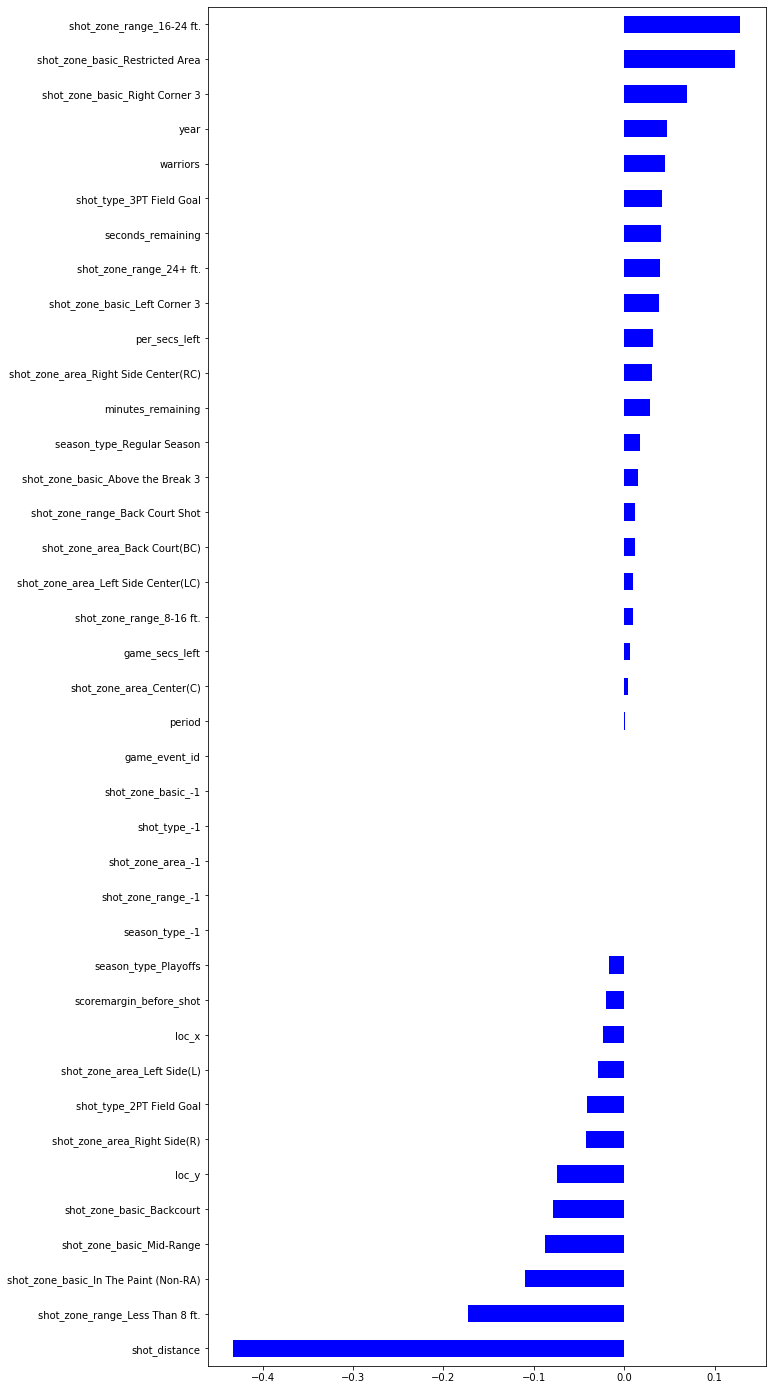

In [137]:
#plot coefficients

coefficients = pd.Series(model.coef_[0], x_train_encoded.columns)
plt.figure(figsize=(10,25))
coefficients.sort_values().plot.barh(color='blue');

In [138]:
a = 85+ 36 
a

#total correct

121

In [139]:
b = 85 + 58 + 8 + 36
b

#total predictions

187

In [118]:
accuracy = a / b
precision = 36 / (36 + 58)
recall = 36 / (36 + 8)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.6470588235294118
Precision: 0.3829787234042553
Recall: 0.8181818181818182
